<a href="https://colab.research.google.com/github/tomasisara-pixel/24hbs_projectwork/blob/main/Project_work_24hbs_13_12_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Project Work - 24 ore Business School**

*Master Big Data, Intelligenza Artificiale e Business Analytics*



**Business Goal:**
The goal of this project is to predict the discounted sales price of Amazon products based on their attributes (such as category, rating, number of reviews etc) in order to support data-driven pricing strategies and optimize promotional decisions aimed at
maximizing sales and profitability or identify high-performing product segments.

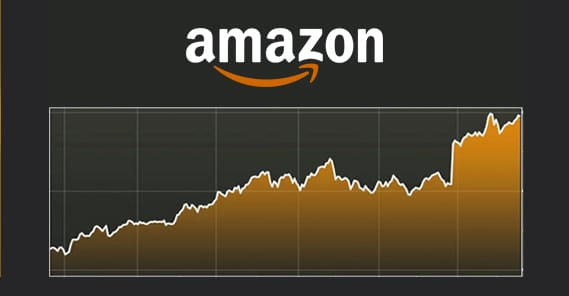

The project is structured into two phases.

**Phase 1 - Data Intelligence**

Predictive Modeling: application of traditional Machine Learning techniques for predictive analysis and classification, aimed at identifying key factors influencing sales performance and forecasting future trends.

**Phase 2 - Conversational Insight Assistant**

Development of a conversational system based on Generative AI with a Retrieval-Augmented Generation (RAG) approach, enabling
interactive exploration of insights and dynamic querying of the sales data.

# **# Phase 1 - Data Intelligence**

*1.1 Data Scrubbing*

In [84]:
#Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
#Importing data
data = pd.read_csv('/content/drive/MyDrive/24HBS_AI/PW/amazon.csv')

In [86]:
#Analyzing dataset - columns
data.columns

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [87]:
# Dropping links columns - unuseful
columns_to_drop = ['img_link', 'product_link', 'user_name']
data = data.drop(columns=columns_to_drop, errors='ignore')

print("Remaining columns:")
display(data.columns)

Remaining columns:


Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'review_id', 'review_title',
       'review_content'],
      dtype='object')

In [88]:
# Looking for duplicates (excluded rating count - oddly specific but needed)
duplicate_subset_cols = ['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating',
       'about_product', 'user_id', 'review_id', 'review_title',
       'review_content']

duplicates_before_drop = data.duplicated(subset=duplicate_subset_cols).sum()
print(f"Number of duplicate rows found before dropping: {duplicates_before_drop}")

if duplicates_before_drop > 0:
    # Sorting by 'rating_count' in descending order to keep only the highest value (in powerBi analysis found duplicates with difference +1 in rating count. error)
    data_sorted = data.sort_values(by=duplicate_subset_cols + ['rating_count'], ascending=[True]*len(duplicate_subset_cols) + [False])
    data_cleaned = data_sorted.drop_duplicates(subset=duplicate_subset_cols, keep='first')

    # Update the original DataFrame
    data = data_cleaned
    print(f"Dropped {duplicates_before_drop} duplicate rows. New DataFrame shape: {data.shape}")
else:
    print("No duplicates found based on the specified subset of columns. No rows dropped.")



Number of duplicate rows found before dropping: 89
Dropped 89 duplicate rows. New DataFrame shape: (1376, 13)


In [89]:
#UGH! scrubbing data - numbers (no commas, no INR symbol)

data = data.copy()

data.loc[:, 'discounted_price'] = (
    data['discounted_price']
    .str.replace("₹", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

data.loc[:, 'actual_price'] = (
    data['actual_price']
    .str.replace("₹", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

data.loc[:, 'rating_count'] = (
    data['rating_count']
    .str.replace(",", "", regex=False)
    .astype(float)
)

data.loc[:, 'discount_percentage'] = (
    data['discount_percentage']
    .str.replace("%", "", regex=False)
    .astype(float) / 100
)

#Exchange to EU
exchange_rate_inr_to_eur = 90
data.loc[:, 'actual_price_EU'] = data['actual_price'] / exchange_rate_inr_to_eur
data.loc[:, 'discounted_price_EU'] = data['discounted_price'] / exchange_rate_inr_to_eur

# Dropping original columns
data = data.drop(columns=['discounted_price', 'actual_price'])

In [90]:
# Values in rating count
data.pivot_table('rating_count' , index = 'rating' , aggfunc='sum')

,rating_count
rating,
2,2.0
2.3,13.0
2.6,24.0
2.8,196.0
2.9,159.0
3,617.0
3.0,784.0
3.1,6089.0
3.2,398.0


In [91]:
# Let's find the row with '|', dropping it and converting to number
data.query('rating == "|"')
data_filtered = data[data['rating'].astype(str) == '|']
data_drop = data_filtered.index
data = data.drop(data_drop)
data['rating'] = data['rating'].astype('float64')

data.pivot_table('rating_count' , index = 'rating' , aggfunc='sum')




,rating_count
rating,
2.0,2.0
2.3,13.0
2.6,24.0
2.8,196.0
2.9,159.0
3.0,1401.0
3.1,6089.0
3.2,398.0
3.3,41386.0


In [92]:
#Overlooking dataset - category
print(data['category'].value_counts())

category
Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables          174
Electronics|WearableTechnology|SmartWatches                                                 70
Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                        68
Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                               60
Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                                51
                                                                                          ... 
Electronics|Mobiles&Accessories|MobileAccessories|Mounts|HandlebarMounts                     1
Computers&Accessories|Laptops|TraditionalLaptops                                             1
Home&Kitchen|Kitchen&HomeAppliances|Coffee,Tea&Espresso|CoffeeGrinders|ElectricGrinders      1
Electronics|Mobiles&Accessories|MobileAccessories|Décor|PhoneCharms                          1
Computers&Accessories|Components|Internal

In [93]:
# Splitting category
catsplit = data['category'].str.split('|', expand=True)
data['cat_area'] = catsplit[0]
data['macrocat'] = catsplit[1]

print("DataFrame 'data' columns after split:")
display(data.columns)

DataFrame 'data' columns after split:


Index(['product_id', 'product_name', 'category', 'discount_percentage',
       'rating', 'rating_count', 'about_product', 'user_id', 'review_id',
       'review_title', 'review_content', 'actual_price_EU',
       'discounted_price_EU', 'cat_area', 'macrocat'],
      dtype='object')

In [94]:
#let's scrub category into the last part of the string that identifies single product
category_scrubbed = data['category'].str.split('|').str[-1]
data['category'] = category_scrubbed #warning!!!!!! overscribing


print(data['category'].value_counts())


category
USBCables             174
SmartWatches           70
Smartphones            68
SmartTelevisions       60
In-Ear                 51
                     ... 
HandlebarMounts         1
TraditionalLaptops      1
ElectricGrinders        1
PhoneCharms             1
InternalHardDrives      1
Name: count, Length: 207, dtype: int64


In [95]:
# Scrubbing text: lowercasing, removing punctuation, findind NaN values, tokenizing and joining in a string
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt') # Ensure basic punkt tokenizer is downloaded
nltk.download('punkt_tab') # Download punkt_tab as per the LookupError

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

data['cleaned_review_content'] = data['review_content'].apply(preprocess_text)
data['cleaned_about_product'] = data['about_product'].apply(preprocess_text)
data['cleaned_product_name'] = data['product_name'].apply(preprocess_text)
data['cleaned_category'] = data['category'].apply(preprocess_text)
data['cleaned_macrocat'] = data['macrocat'].apply(preprocess_text)
data['cleaned_cat_area'] = data['cat_area'].apply(preprocess_text)
data['cleaned_review_title'] = data['review_title'].apply(preprocess_text)
data['cleaned_product_id'] = data['product_id'].apply(preprocess_text)

# Dropping original text columns
data = data.drop(columns=['review_content', 'about_product', 'product_name', 'macrocat','category', 'cat_area', 'review_title', 'product_id'], errors='ignore')
data.columns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Index(['discount_percentage', 'rating', 'rating_count', 'user_id', 'review_id',
       'actual_price_EU', 'discounted_price_EU', 'cleaned_review_content',
       'cleaned_about_product', 'cleaned_product_name', 'cleaned_category',
       'cleaned_macrocat', 'cleaned_cat_area', 'cleaned_review_title',
       'cleaned_product_id'],
      dtype='object')

In [97]:
#Adding a review content's sentiment score
from textblob import TextBlob

def get_sentiment(text):
      if pd.isna(text):
        return 0
      return TextBlob(str(text)).sentiment.polarity

series_to_apply = data['cleaned_review_content']

data['review_sentiment'] = series_to_apply.apply(get_sentiment)

print(data[['cleaned_review_content', 'review_sentiment']].head())

                                cleaned_review_content  review_sentiment
46   good quality tool linkwifi signal goodnice pro...          0.450000
143  use connect old pc internet tried lubuntu 20 u...          0.328180
721  works goodbought replace phillips qt4005 trimm...          0.344215
724  liked producthttpsmmediaamazoncomimagesi710c5j...          0.668182
734  little small big hands best available marketgo...          0.176343


In [98]:
data.shape

(1375, 16)

In [99]:
data.to_csv('/content/drive/MyDrive/24HBS_AI/PW/amazon_cleaned.csv')

*1.2 Data Exploring*

In [100]:
#Importing libraries again, gotta use this section as separate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from google.colab import drive
drive.mount('/content/drive')


data_scrubbed = pd.read_csv('/content/drive/MyDrive/24HBS_AI/PW/amazon_cleaned.csv', index_col=0)
data_scrubbed.columns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Index(['discount_percentage', 'rating', 'rating_count', 'user_id', 'review_id',
       'actual_price_EU', 'discounted_price_EU', 'cleaned_review_content',
       'cleaned_about_product', 'cleaned_product_name', 'cleaned_category',
       'cleaned_macrocat', 'cleaned_cat_area', 'cleaned_review_title',
       'cleaned_product_id', 'review_sentiment'],
      dtype='object')

In [101]:
# Calculate the total sum of 'rating_count'
total_rating_count = data_scrubbed['rating_count'].sum()
print(f"Total sum of rating_count: {total_rating_count}")

Total sum of rating_count: 24396109.0


Descriptive statistics for discounted price:


,discount_percentage
count,1375.000000
mean,0.470044
std,0.217491
min,0.000000
25%,0.310000
50%,0.490000
75%,0.630000
max,0.940000


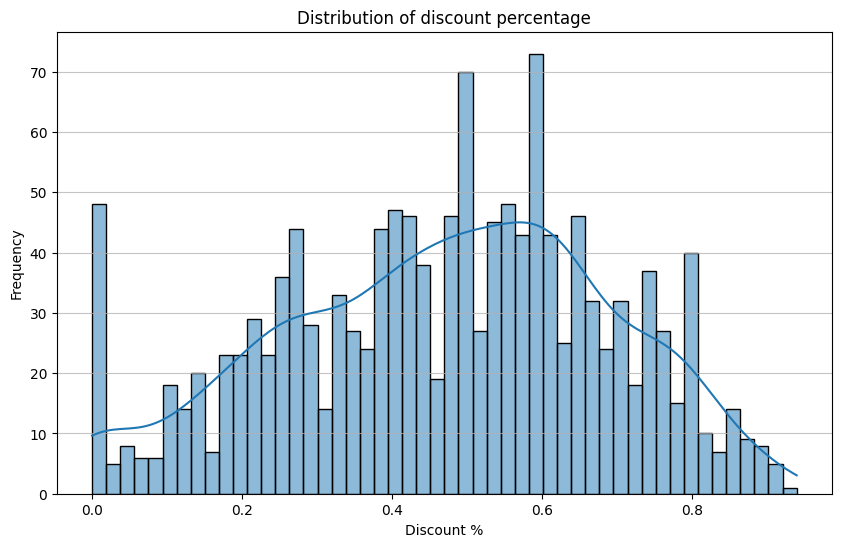

In [102]:
# Let's explore data: descriptive statistics for discount percentage, my target
print("Descriptive statistics for discounted price:")
display(data_scrubbed['discount_percentage'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(data_scrubbed['discount_percentage'], kde=True, bins=50)
plt.title('Distribution of discount percentage')
plt.xlabel('Discount %')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Descriptive statistics for discounted price:


,discounted_price_EU
count,1375.000000
mean,36.231016
std,79.105388
min,0.433333
25%,3.877778
50%,9.877778
75%,23.300000
max,866.555556


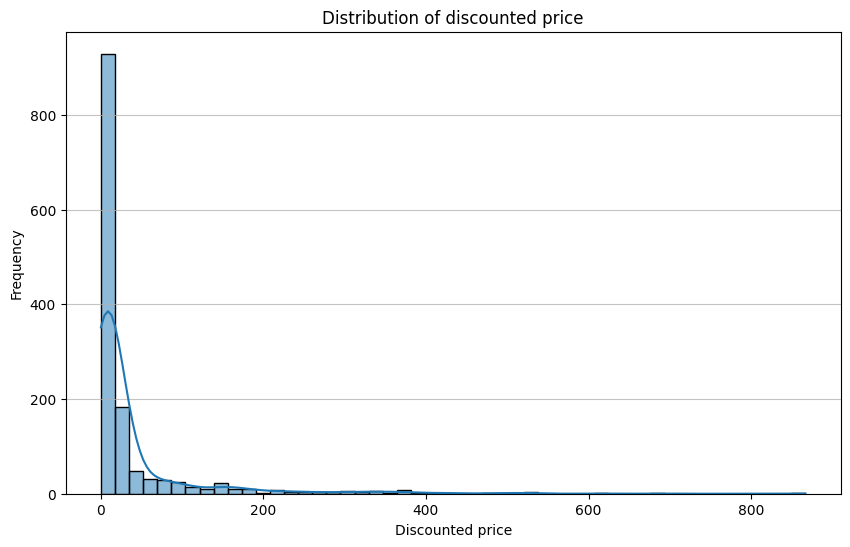

In [103]:
# Distribution for discounted price
print("Descriptive statistics for discounted price:")
display(data_scrubbed['discounted_price_EU'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(data_scrubbed['discounted_price_EU'], kde=True, bins=50)
plt.title('Distribution of discounted price')
plt.xlabel('Discounted price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Descriptive statistics for actual price:


,actual_price_EU
count,1375.000000
mean,62.667784
std,123.705212
min,0.433333
25%,9.988889
50%,19.433333
75%,51.055556
max,1554.444444


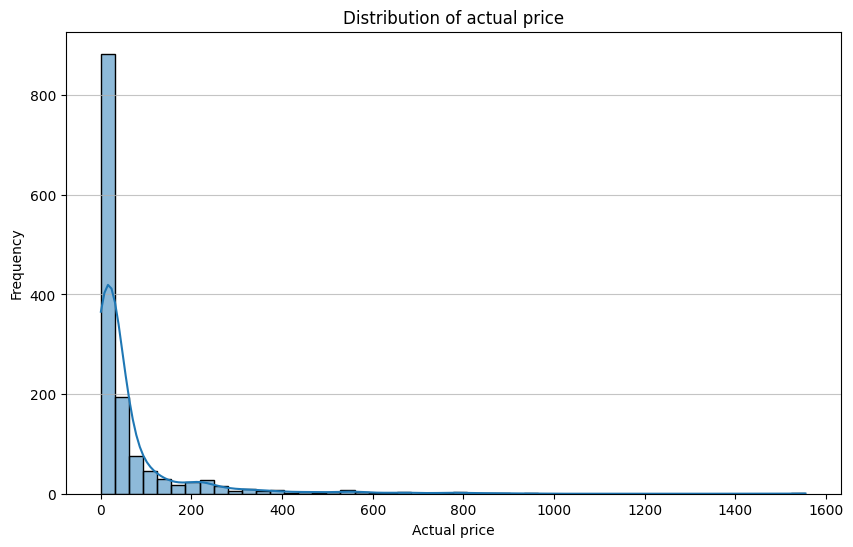

In [104]:
#Distribution of actual price
print("Descriptive statistics for actual price:")
display(data_scrubbed['actual_price_EU'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(data_scrubbed['actual_price_EU'], kde=True, bins=50)
plt.title('Distribution of actual price')
plt.xlabel('Actual price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Descriptive statistics for rating:


,rating
count,1375.000000
mean,4.092145
std,0.295841
min,2.000000
25%,3.900000
50%,4.100000
75%,4.300000
max,5.000000


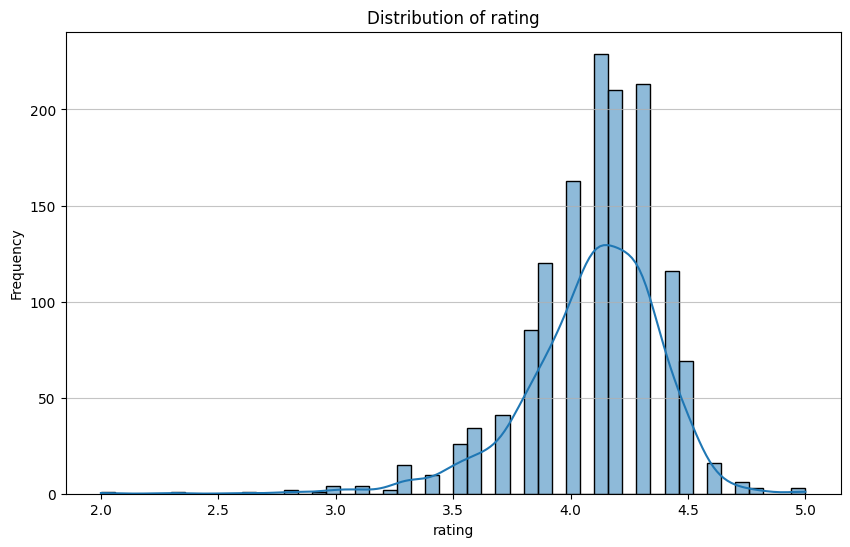

In [105]:
# Descriptive statistics for rating
print("Descriptive statistics for rating:")
display(data_scrubbed['rating'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(data_scrubbed['rating'], kde=True, bins=50)
plt.title('Distribution of rating')
plt.xlabel('rating')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Descriptive statistics for rating count:


,rating_count
count,1373.000000
mean,17768.469774
std,41943.777447
min,2.000000
25%,1161.000000
50%,4959.000000
75%,16685.000000
max,426973.000000


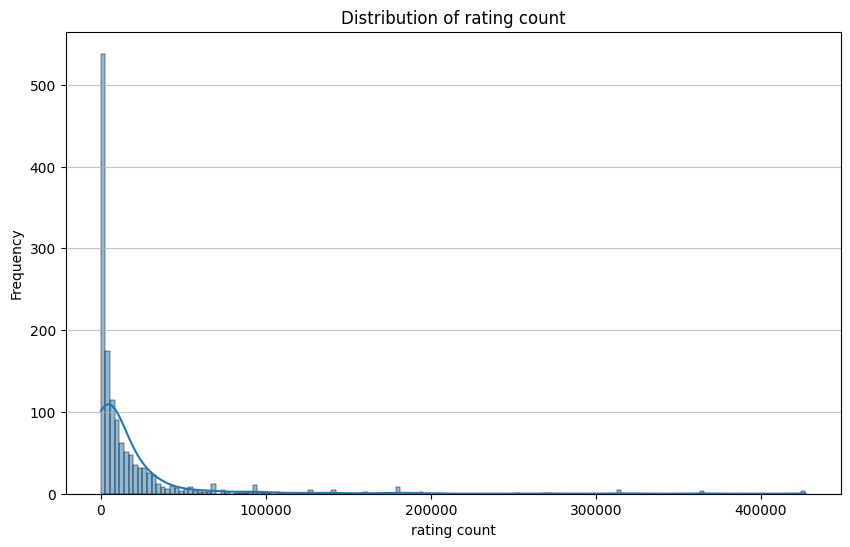

In [106]:
# Descriptive statistics for rating count
print("Descriptive statistics for rating count:")
display(data_scrubbed['rating_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(data_scrubbed['rating_count'], kde=True)
plt.title('Distribution of rating count')
plt.xlabel('rating count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

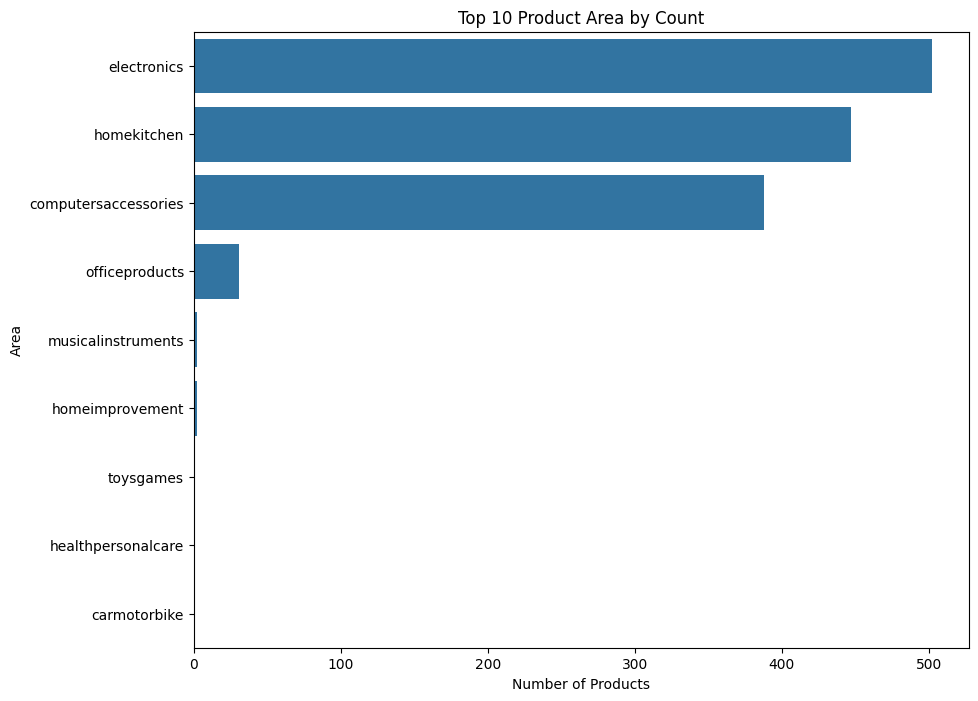

In [107]:
#Top 10 commons productsby area

plt.figure(figsize=(10,8))
top_categories = data_scrubbed['cleaned_cat_area'].value_counts().nlargest(20)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 10 Product Area by Count")
plt.xlabel("Number of Products")
plt.ylabel("Area")
plt.show()

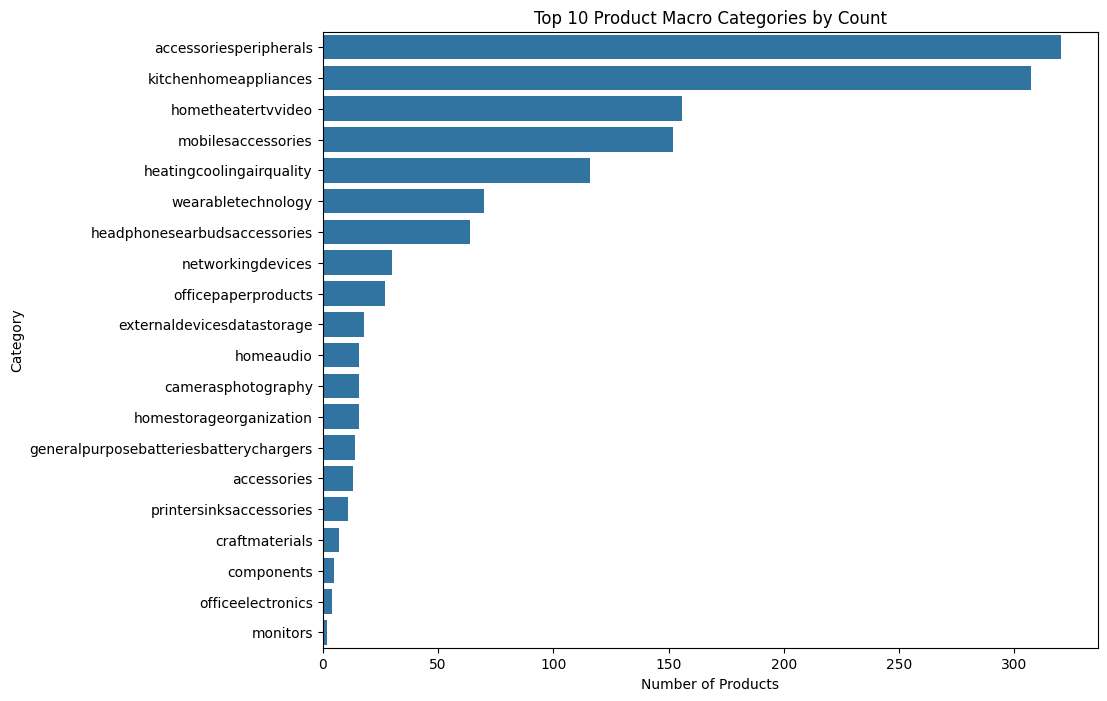

In [108]:
#Top 10 commons product by macrocategory

plt.figure(figsize=(10,8))
top_categories = data_scrubbed['cleaned_macrocat'].value_counts().nlargest(20)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 10 Product Macro Categories by Count")
plt.xlabel("Number of Products")
plt.ylabel("Category")
plt.show()



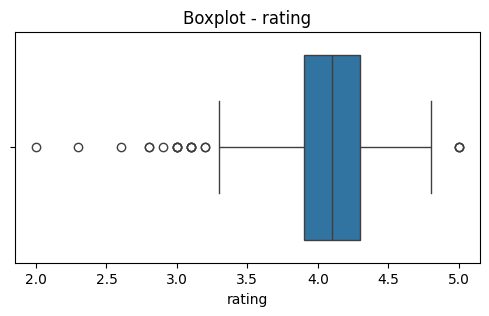

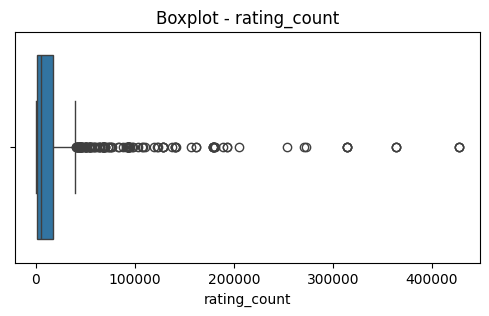

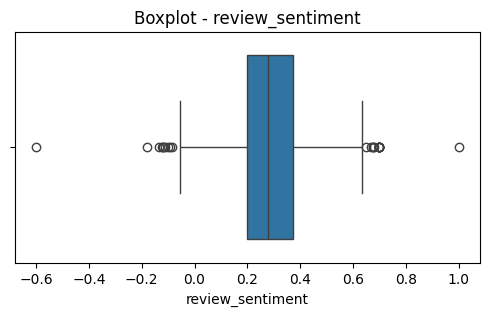

In [109]:
#looking for outliers (1.5xIQR) --> inserted a log transformation in pre-processing to reduce skewness in rating count
# Given that the semantic validation was ok and I've chosen CatBoost, that is generally robust to outlier, we maintain features rating and review sentiments as is
num_cols = ["rating", "rating_count", "review_sentiment"]

for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=data_scrubbed[col]) # Corrected 'data' to 'data_scrubbed'
    plt.title(f"Boxplot - {col}")
    plt.show()

In [110]:
# Semantic validation rating
data_scrubbed[data_scrubbed['rating'] < 3][['rating', 'cleaned_review_content']]


,rating,cleaned_review_content
1356,2.6,broken useful please change productproduct pla...
1449,2.9,stop working daysokit doesnt fit easily little...
545,2.8,good prodatbattery life badnice productdislike...
1243,2.3,liked convenient carrywaste money defective pr...
1286,2.8,sufficient powerthe product like toy kids cant...
1309,2.0,heating capacity zero moreover initiated retur...


In [111]:
# Semantic validation review sentiment
data_scrubbed[(data_scrubbed['review_sentiment'] < -0.5) | (data_scrubbed['review_sentiment'] > 0.9)][['review_sentiment', 'cleaned_review_content']]

,review_sentiment,cleaned_review_content
302,1.0,okquality perfect perfect 5m must buyokexcelle...
155,-0.6,tv working difficult battery really bad product


Minimum rating count: 2.0
Maximum rating count: 426973.0


,mean,std
,discount_percentage,discount_percentage
rating_count_bins_equal,,
0.0,0.468027,0.220297
1.0,0.469500,0.184955
2.0,0.535833,0.159644
3.0,0.497500,0.231325
4.0,0.478333,0.145467
5.0,0.560000,NaN
6.0,0.450000,0.212132
7.0,0.217500,0.022174


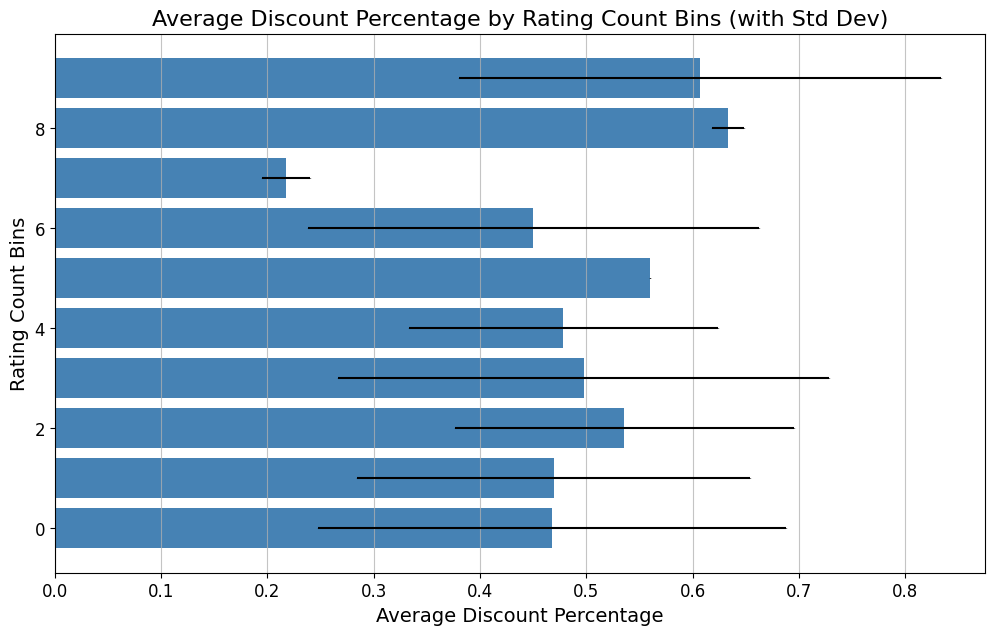

In [112]:
# Exploring discount percentage and rating count. Splitting in with equal-width bins... adding std deviation
# Create a temporary copy to avoid modifying the original dataset
data_temp = data_scrubbed.copy()

min_rating_count = data_temp['rating_count'].min()
max_rating_count = data_temp['rating_count'].max()

print(f"Minimum rating count: {min_rating_count}")
print(f"Maximum rating count: {max_rating_count}")

num_bins = 10
bins_edges = np.linspace(0, max_rating_count, num_bins + 1)
data_temp['rating_count_bins_equal'] = pd.cut(data_temp['rating_count'], bins=bins_edges, labels=False, include_lowest=True)

pivot_table_discount_reviews_equal_bins = data_temp.pivot_table(values='discount_percentage', index='rating_count_bins_equal', aggfunc=['mean', 'std'])
display(pivot_table_discount_reviews_equal_bins)

#Vizualizing it
df_plot = pivot_table_discount_reviews_equal_bins.copy()
df_plot.columns = ['mean_discount_percentage', 'std_discount_percentage']
df_plot = df_plot.reset_index()

df_plot['std_discount_percentage'] = df_plot['std_discount_percentage'].fillna(0)

plt.figure(figsize=(12, 7))
plt.barh(y=df_plot['rating_count_bins_equal'],
         width=df_plot['mean_discount_percentage'],
         xerr=df_plot['std_discount_percentage'],
         capsize=0.2,
         color='steelblue')

plt.title('Average Discount Percentage by Rating Count Bins (with Std Dev)', fontsize=16)
plt.xlabel('Average Discount Percentage', fontsize=14)
plt.ylabel('Rating Count Bins', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', alpha=0.75)
plt.show()

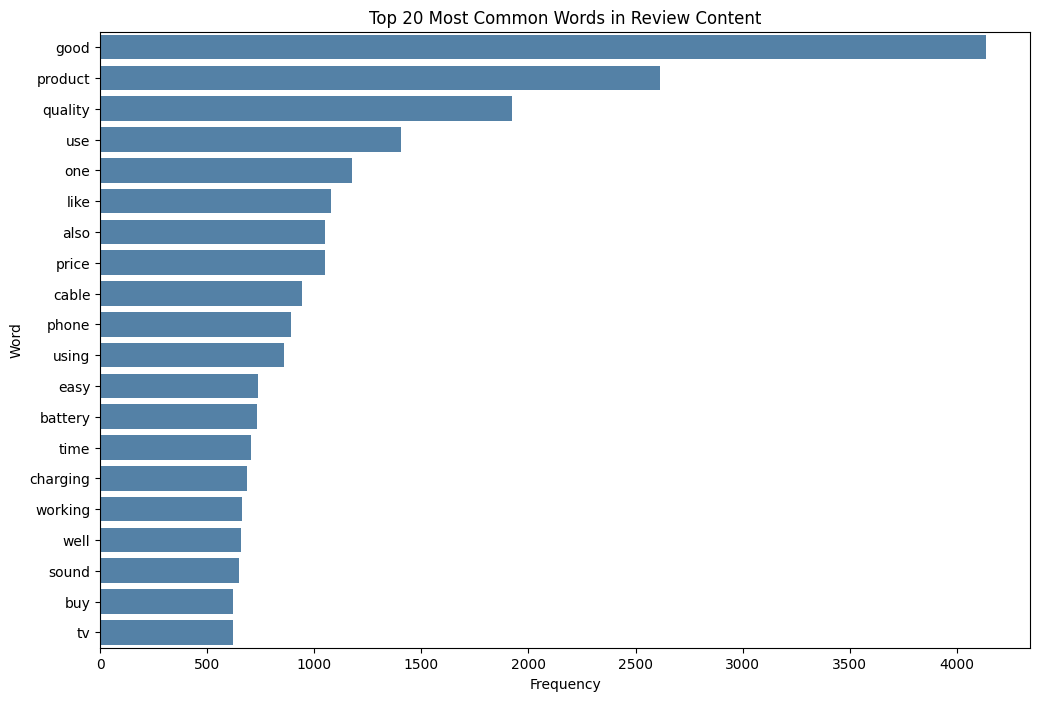

In [113]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Combining all into a single string and looking for 20 most common words
all_cleaned_reviews = ' '.join(data_scrubbed['cleaned_review_content'].dropna().astype(str))
words = all_cleaned_reviews.split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Visualizing
most_common_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=most_common_df, color='steelblue')
plt.title('Top 20 Most Common Words in Review Content')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

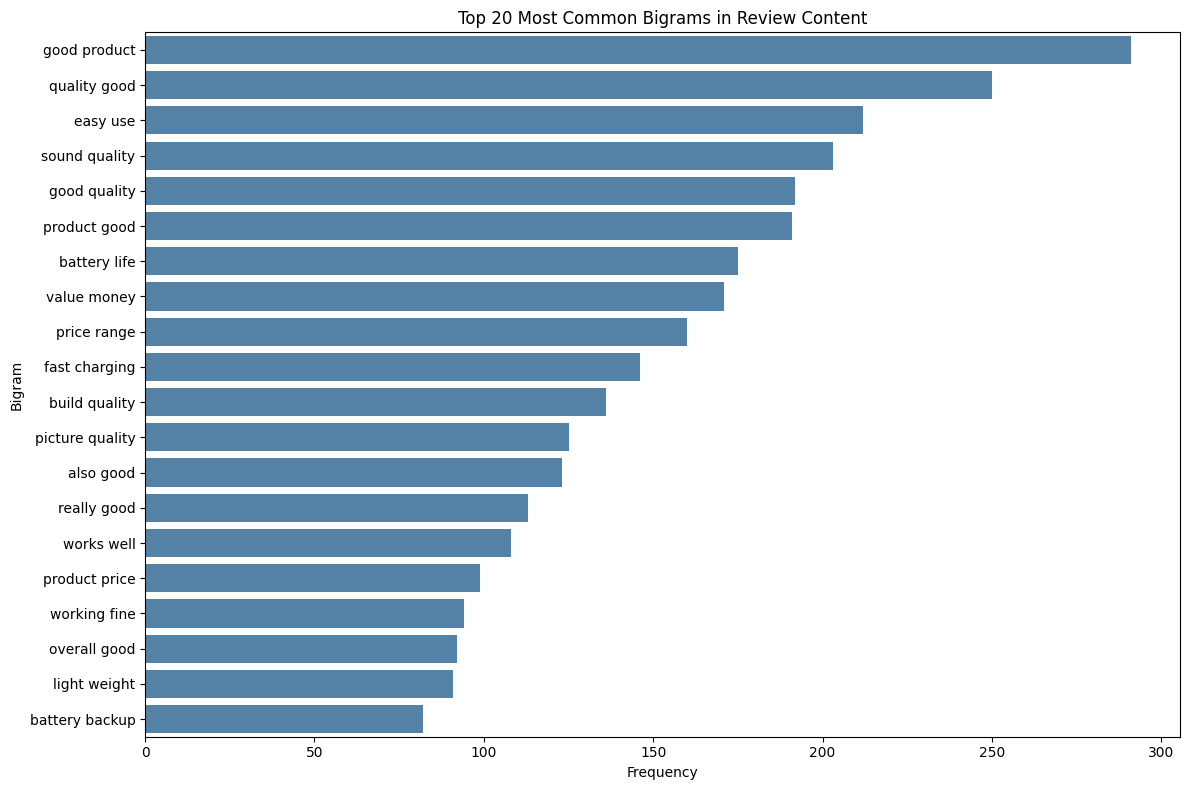

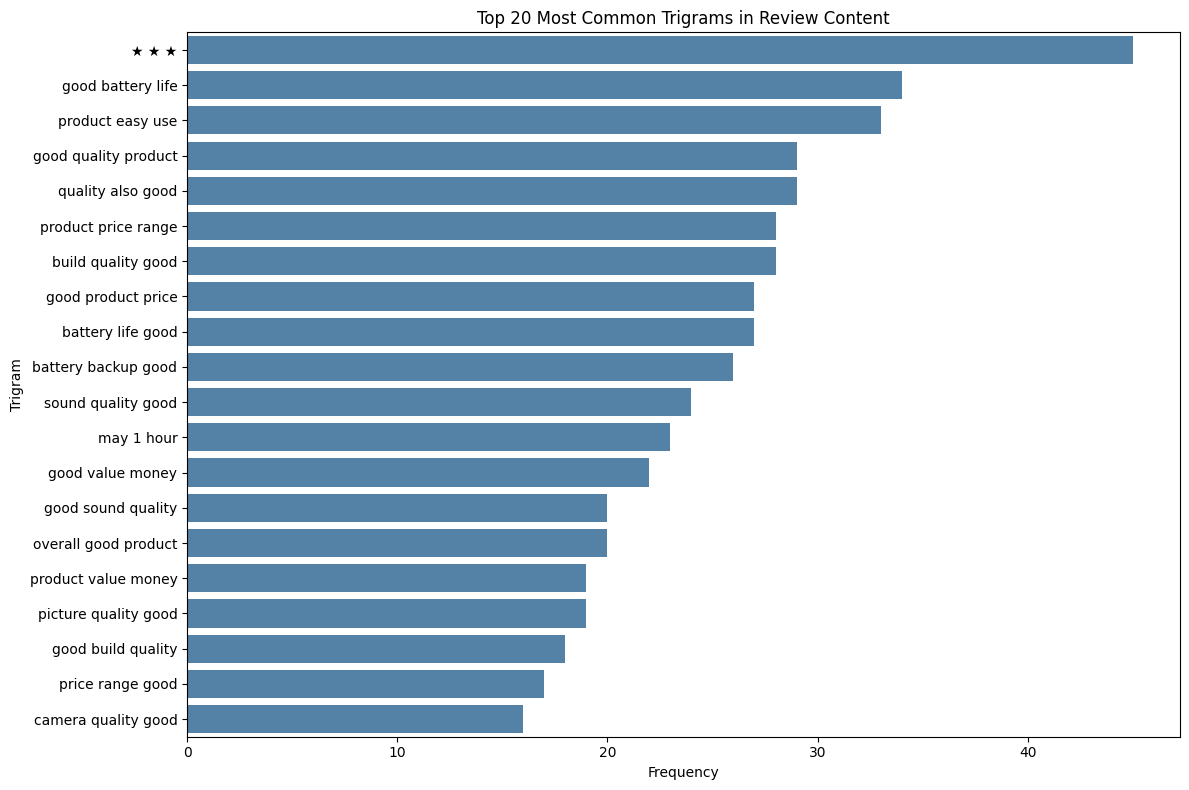

In [114]:
# Maybe bigrams? Or trigrams?
from nltk.util import ngrams
words = all_cleaned_reviews.split()

bigrams = list(ngrams(words, 2))
bigram_counts = Counter(bigrams)
most_common_bigrams = bigram_counts.most_common(20)
most_common_bigrams_str = [(' '.join(bigram), count) for bigram, count in most_common_bigrams]


most_common_bigrams_df = pd.DataFrame(most_common_bigrams_str, columns=['Bigram', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Bigram', data=most_common_bigrams_df, color='steelblue')
plt.title('Top 20 Most Common Bigrams in Review Content')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.tight_layout()
plt.show()

trigrams = list(ngrams(words, 3))
trigram_counts = Counter(trigrams)
most_common_trigrams = trigram_counts.most_common(20)
most_common_trigrams_str = [(' '.join(trigram), count) for trigram, count in most_common_trigrams]

most_common_trigrams_df = pd.DataFrame(most_common_trigrams_str, columns=['Trigram', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Trigram', data=most_common_trigrams_df, color='steelblue')
plt.title('Top 20 Most Common Trigrams in Review Content')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.tight_layout()
plt.show()

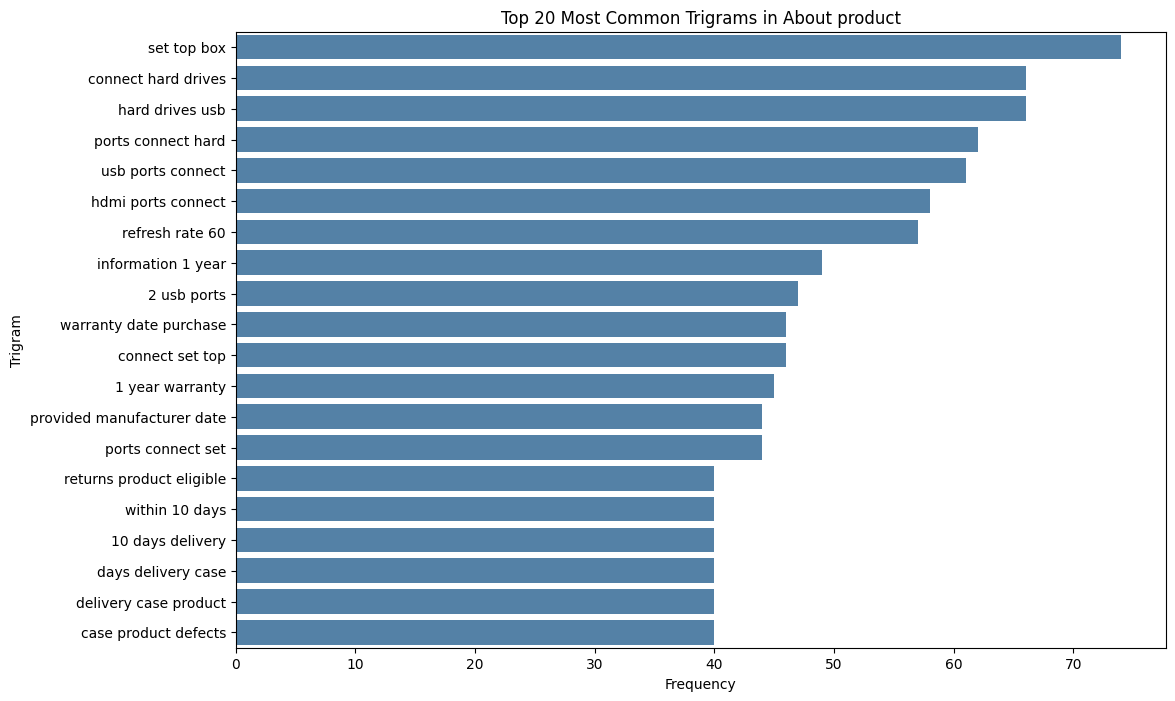

In [115]:
#Something interesting in about product?
all_cleaned_reviews = ' '.join(data_scrubbed['cleaned_about_product'].dropna().astype(str))
words = all_cleaned_reviews.split()

trigrams = list(ngrams(words, 3))
trigram_counts = Counter(trigrams)
most_common_trigrams = trigram_counts.most_common(20)
most_common_trigrams_str = [(' '.join(trigram), count) for trigram, count in most_common_trigrams]

most_common_trigrams_df = pd.DataFrame(most_common_trigrams_str, columns=['Trigram', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Trigram', data=most_common_trigrams_df, color='steelblue')
plt.title('Top 20 Most Common Trigrams in About product')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()

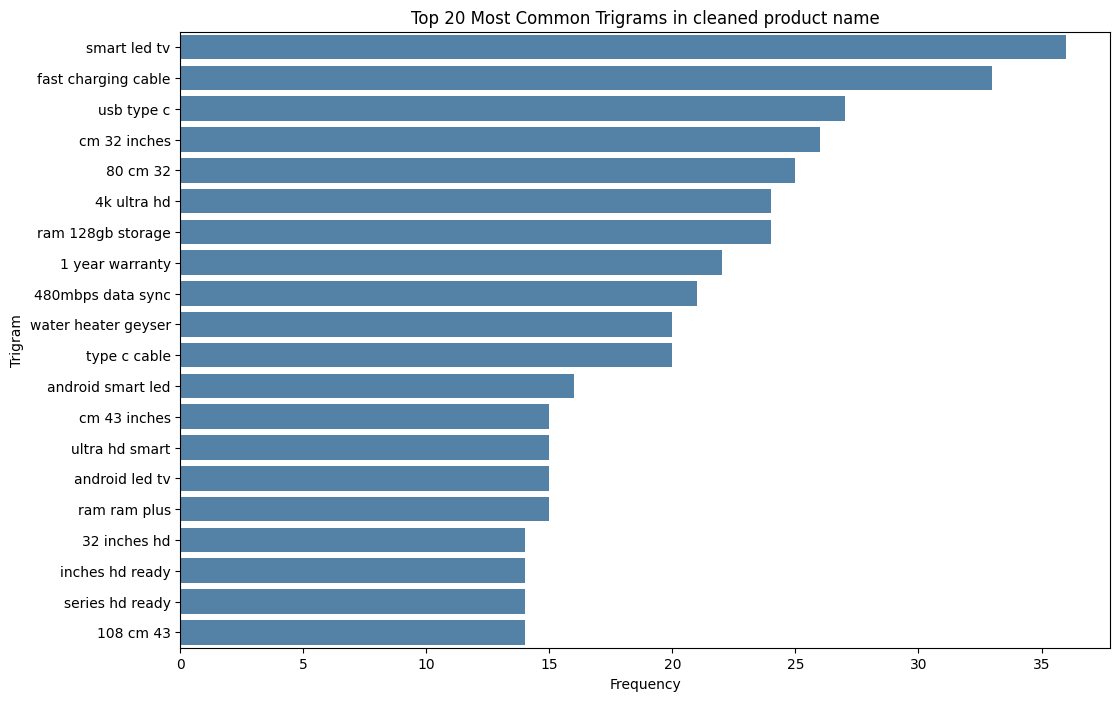

In [116]:
#Something interesting in product name?

all_cleaned_reviews = ' '.join(data_scrubbed['cleaned_product_name'].dropna().astype(str))
words = all_cleaned_reviews.split()

trigrams = list(ngrams(words, 3))
trigram_counts = Counter(trigrams)
most_common_trigrams = trigram_counts.most_common(20)
most_common_trigrams_str = [(' '.join(trigram), count) for trigram, count in most_common_trigrams]

most_common_trigrams_df = pd.DataFrame(most_common_trigrams_str, columns=['Trigram', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Trigram', data=most_common_trigrams_df, color='steelblue')
plt.title('Top 20 Most Common Trigrams in cleaned product name')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.show()

Numerical columns identified:
Index(['discount_percentage', 'rating', 'rating_count', 'actual_price_EU',
       'discounted_price_EU', 'review_sentiment'],
      dtype='object')

Correlation Matrix calculated:
                     discount_percentage    rating  rating_count  \
discount_percentage             1.000000 -0.166033      0.007855   
rating                         -0.166033  1.000000      0.097479   
rating_count                    0.007855  0.097479      1.000000   
actual_price_EU                -0.112534  0.125283     -0.034347   
discounted_price_EU            -0.237634  0.125183     -0.024669   

                     actual_price_EU  discounted_price_EU  review_sentiment  
discount_percentage        -0.112534            -0.237634          0.047562  
rating                      0.125283             0.125183          0.148135  
rating_count               -0.034347            -0.024669         -0.019615  
actual_price_EU             1.000000             0.962060         -0.

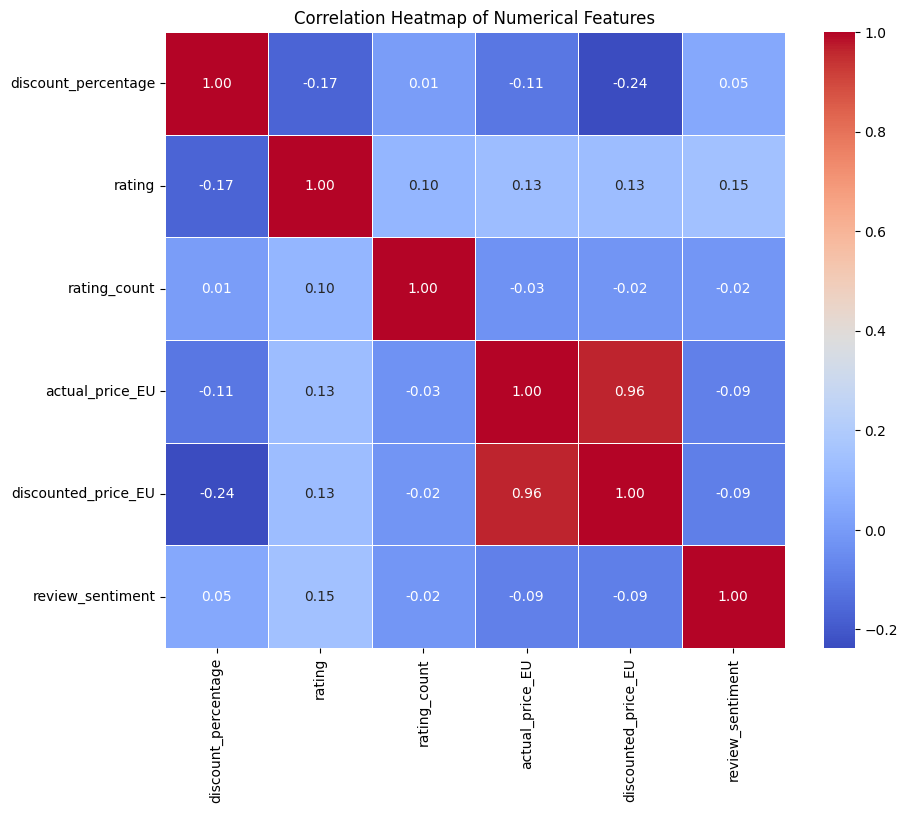

In [117]:
#Heatmap
numerical_cols = data_scrubbed.select_dtypes(include=np.number).columns
print("Numerical columns identified:")
print(numerical_cols)

correlation_matrix = data_scrubbed[numerical_cols].corr()
print("\nCorrelation Matrix calculated:")
print(correlation_matrix.head())

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [118]:
data_scrubbed.to_csv('/content/drive/MyDrive/24HBS_AI/PW/amazon_to_ML.csv')

In [119]:
#Lesson learned:

# The correlation between rating and discounted price turns out to be quite weak (Pearson 0,13) and is actually the same existing between rating and actual price.
# The correlation between rating and review sentiment is quite weak too (0,15)
# no correlation between rating count and discounted percentage
# Word analysis in bigrams or trigrams: easy use, fast charging, good battery life, sound quality...
# Target will be discount percentage, and i will surely analyze text

1.3. Data modeling

In [120]:
#Importing libraries again, gotta use this section as separate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from google.colab import drive
drive.mount('/content/drive')
data_train = pd.read_csv('/content/drive/MyDrive/24HBS_AI/PW/amazon_to_ML.csv', index_col=0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
# Filling missing values

print("""MISSING VALUES
> FULL DATASET
{}
""".format(data_train.isnull().sum()))

missing_summary = pd.DataFrame({
    'missing_count': data_train.isnull().sum(),
    'missing_pct': data_train.isnull().mean() * 100
})
print(missing_summary)

# Rating_count mean
mean_value = data_train['rating_count'].mean()

# Filling
data_train['rating_count'] = data_train['rating_count'].fillna(mean_value)

print("""MISSING VALUES
> AFTER FILL
{}
""".format(data_train.isnull().sum()))



MISSING VALUES
> FULL DATASET
discount_percentage       0
rating                    0
rating_count              2
user_id                   0
review_id                 0
actual_price_EU           0
discounted_price_EU       0
cleaned_review_content    0
cleaned_about_product     0
cleaned_product_name      0
cleaned_category          0
cleaned_macrocat          0
cleaned_cat_area          0
cleaned_review_title      0
cleaned_product_id        0
review_sentiment          0
dtype: int64

                        missing_count  missing_pct
discount_percentage                 0     0.000000
rating                              0     0.000000
rating_count                        2     0.145455
user_id                             0     0.000000
review_id                           0     0.000000
actual_price_EU                     0     0.000000
discounted_price_EU                 0     0.000000
cleaned_review_content              0     0.000000
cleaned_about_product               0     0.00000

In [122]:
# Splitting data_train_y selecting target variable

data_train_y = data_train['discount_percentage']

# Save product_id separately before feature selection
ids_original = data_train['cleaned_product_id']

# features to exclude from data_train_x
columns_to_exclude_from_X = [
    'discount_percentage', 'discounted_price_EU', 'actual_price_EU', #trying to avoid leakage, target is the ratio between prizes
    'user_id',
    'review_id',
    'cleaned_product_id' # Exclude product_id from features
  ]

all_data_train_columns = data_train.columns.tolist()
feature_cols_for_X = [col for col in all_data_train_columns if col not in columns_to_exclude_from_X]

data_train_x = data_train[feature_cols_for_X]

X = data_train_x.reset_index(drop=True)
y = data_train_y.reset_index(drop=True)

print(f"Shape of features (data_train_x): {data_train_x.shape}")
print(f"Shape of target (data_train_y): {data_train_y.shape}")

print("Columns in X:")
display(X.columns)
print("Data types in X:")
display(X.dtypes)

Shape of features (data_train_x): (1375, 10)
Shape of target (data_train_y): (1375,)
Columns in X:


Index(['rating', 'rating_count', 'cleaned_review_content',
       'cleaned_about_product', 'cleaned_product_name', 'cleaned_category',
       'cleaned_macrocat', 'cleaned_cat_area', 'cleaned_review_title',
       'review_sentiment'],
      dtype='object')

Data types in X:


,0
rating,float64
rating_count,float64
cleaned_review_content,object
cleaned_about_product,object
cleaned_product_name,object
cleaned_category,object
cleaned_macrocat,object
cleaned_cat_area,object
cleaned_review_title,object
review_sentiment,float64


In [4]:
#First thing first: importing library to split test and validation subsets

from sklearn.model_selection import train_test_split

# Split features, target, and product_ids together
x_train_temp, x_test, y_train_temp, y_test, ids_train_temp, ids_test = train_test_split(
    data_train_x, data_train_y, ids_original, # Include ids
    random_state=42,
    test_size=0.15
)

x_train, x_val, y_train, y_val, ids_train, ids_val = train_test_split(
    x_train_temp, y_train_temp, ids_train_temp, # Include ids
    random_state=42,
    test_size=0.2
)

print(f"Shape of data_train_x: {data_train_x.shape}")
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of ids_train: {ids_train.shape}")
print(f"Shape of ids_val: {ids_val.shape}")
print(f"Shape of ids_test: {ids_test.shape}")

Shape of data_train_x: (1375, 11)
Shape of x_train: (934, 11)
Shape of x_val: (234, 11)
Shape of x_test: (207, 11)
Shape of y_train: (934,)
Shape of y_val: (234,)
Shape of y_test: (207,)
Shape of ids_train: (934,)
Shape of ids_val: (234,)
Shape of ids_test: (207,)


In [5]:
# Checking for non-numeric columns

feature_columns = x_train.columns
actual_feature_columns = [col for col in feature_columns if col in data_train.columns]

data_train_x = data_train[actual_feature_columns]
X = data_train_x.reset_index(drop=True)

non_numeric_cols = X.select_dtypes(exclude=np.number).columns

if not non_numeric_cols.empty:
    print("Columns (non-numeric):")
    display(non_numeric_cols)
else:
    print("All columns in X are numeric. Random Forest Regressor can process them directly.")

Columns (non-numeric):


Index(['cleaned_review_content', 'cleaned_about_product',
       'cleaned_product_name', 'cleaned_category', 'cleaned_macrocat',
       'cleaned_cat_area', 'cleaned_review_title'],
      dtype='object')

In [6]:
#Working on textual columns: Not sure what model i will use, so i'm including TF-IDF features in sets
#Then binning rating count log

text_cols = [
    'cleaned_review_content',
    'cleaned_about_product',
    'cleaned_product_name',
    'cleaned_category',
    'cleaned_macrocat',
    'cleaned_cat_area',
    'cleaned_review_title',
    ]

# product_id is already excluded from x_train, x_val, x_test. So we don't need to drop it here.
x_train_num = x_train.drop(columns=text_cols)
x_val_num = x_val.drop(columns=text_cols)
x_test_num = x_test.drop(columns=text_cols)

from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Review content
tfidf_review = TfidfVectorizer(max_features=200, stop_words='english', min_df=0.01)

#training
tfidf_review_train = tfidf_review.fit_transform(x_train['cleaned_review_content'].fillna(""))
# validation e test
tfidf_review_val = tfidf_review.transform(x_val['cleaned_review_content'].fillna(""))
tfidf_review_test = tfidf_review.transform(x_test['cleaned_review_content'].fillna(""))

tfidf_review_train_df = pd.DataFrame(tfidf_review_train.toarray(),
                                     columns=[f"rev_{c}" for c in tfidf_review.get_feature_names_out()])

tfidf_review_val_df = pd.DataFrame(tfidf_review_val.toarray(),
                                   columns=[f"rev_{c}" for c in tfidf_review.get_feature_names_out()])

tfidf_review_test_df = pd.DataFrame(tfidf_review_test.toarray(),
                                    columns=[f"rev_{c}" for c in tfidf_review.get_feature_names_out()])

# 2. About product
tfidf_about = TfidfVectorizer(max_features=200, stop_words='english', min_df=0.01)

#trining
tfidf_about_train = tfidf_about.fit_transform(x_train['cleaned_about_product'].fillna(""))
#validation and test
tfidf_about_val = tfidf_about.transform(x_val['cleaned_about_product'].fillna(""))
tfidf_about_test = tfidf_about.transform(x_test['cleaned_about_product'].fillna(""))

tfidf_about_train_df = pd.DataFrame(tfidf_about_train.toarray(),
                                    columns=[f"about_{c}" for c in tfidf_about.get_feature_names_out()])

tfidf_about_val_df = pd.DataFrame(tfidf_about_val.toarray(),
                                  columns=[f"about_{c}" for c in tfidf_about.get_feature_names_out()])

tfidf_about_test_df = pd.DataFrame(tfidf_about_test.toarray(),
                                   columns=[f"about_{c}" for c in tfidf_about.get_feature_names_out()])

# 3. Product name
tfidf_name = TfidfVectorizer(max_features=200, stop_words='english', min_df=0.01)
#Training
tfidf_name_train = tfidf_name.fit_transform(x_train['cleaned_product_name'].fillna(""))
#validation and test
tfidf_name_val = tfidf_name.transform(x_val['cleaned_product_name'].fillna(""))
tfidf_name_test = tfidf_name.transform(x_test['cleaned_product_name'].fillna(""))

tfidf_name_train_df = pd.DataFrame(tfidf_name_train.toarray(),
                                   columns=[f"name_{c}" for c in tfidf_name.get_feature_names_out()])

tfidf_name_val_df = pd.DataFrame(tfidf_name_val.toarray(),
                                 columns=[f"name_{c}" for c in tfidf_name.get_feature_names_out()])

tfidf_name_test_df = pd.DataFrame(tfidf_name_test.toarray(),
                                  columns=[f"name_{c}" for c in tfidf_name.get_feature_names_out()])


#4. Cleaned category
tfidf_cat = TfidfVectorizer(max_features=200, stop_words='english', min_df=0.01)

# Training
tfidf_cat_train = tfidf_cat.fit_transform(x_train['cleaned_category'].fillna(""))

# Validation e Test
tfidf_cat_val = tfidf_cat.transform(x_val['cleaned_category'].fillna(""))
tfidf_cat_test = tfidf_cat.transform(x_test['cleaned_category'].fillna(""))

tfidf_cat_train_df = pd.DataFrame(tfidf_cat_train.toarray(),
                                  columns=[f"cat_{c}" for c in tfidf_cat.get_feature_names_out()])

tfidf_cat_val_df = pd.DataFrame(tfidf_cat_val.toarray(),
                                columns=[f"cat_{c}" for c in tfidf_cat.get_feature_names_out()])

tfidf_cat_test_df = pd.DataFrame(tfidf_cat_test.toarray(),
                                 columns=[f"cat_{c}" for c in tfidf_cat.get_feature_names_out()])


#5. Cleaned macrocat
tfidf_macro = TfidfVectorizer(max_features=200, stop_words='english', min_df=0.01)

# Training
tfidf_macro_train = tfidf_macro.fit_transform(x_train['cleaned_macrocat'].fillna(""))

# Validation e Test
tfidf_macro_val = tfidf_macro.transform(x_val['cleaned_macrocat'].fillna(""))
tfidf_macro_test = tfidf_macro.transform(x_test['cleaned_macrocat'].fillna(""))

tfidf_macro_train_df = pd.DataFrame(tfidf_macro_train.toarray(),
                                    columns=[f"macro_{c}" for c in tfidf_macro.get_feature_names_out()])

tfidf_macro_val_df = pd.DataFrame(tfidf_macro_val.toarray(),
                                  columns=[f"macro_{c}" for c in tfidf_macro.get_feature_names_out()])

tfidf_macro_test_df = pd.DataFrame(tfidf_macro_test.toarray(),
                                   columns=[f"macro_{c}" for c in tfidf_macro.get_feature_names_out()])

#6. cleaned review_title
tfidf_title = TfidfVectorizer(max_features=200, stop_words='english', min_df=0.01)

# Training
tfidf_title_train = tfidf_title.fit_transform(x_train['cleaned_review_title'].fillna(""))

# Validation e Test
tfidf_title_val = tfidf_title.transform(x_val['cleaned_review_title'].fillna(""))
tfidf_title_test = tfidf_title.transform(x_test['cleaned_review_title'].fillna(""))


tfidf_title_train_df = pd.DataFrame(tfidf_title_train.toarray(),
                                    columns=[f"title_{c}" for c in tfidf_title.get_feature_names_out()])

tfidf_title_val_df = pd.DataFrame(tfidf_title_val.toarray(),
                                  columns=[f"title_{c}" for c in tfidf_title.get_feature_names_out()])

tfidf_title_test_df = pd.DataFrame(tfidf_title_test.toarray(),
                                   columns=[f"title_{c}" for c in tfidf_title.get_feature_names_out()])



# TRAIN
x_train_final = pd.concat([
    x_train_num.reset_index(drop=True),
    tfidf_review_train_df,
    tfidf_about_train_df,
    tfidf_name_train_df,
    tfidf_cat_train_df,
    tfidf_macro_train_df,
    tfidf_title_train_df
], axis=1)

# VALIDATION
x_val_final = pd.concat([
    x_val_num.reset_index(drop=True),
    tfidf_review_val_df,
    tfidf_about_val_df,
    tfidf_name_val_df,
    tfidf_cat_val_df,
    tfidf_macro_val_df,
    tfidf_title_val_df
], axis=1)

# TEST
x_test_final = pd.concat([
    x_test_num.reset_index(drop=True),
    tfidf_review_test_df,
    tfidf_about_test_df,
    tfidf_name_test_df,
    tfidf_cat_test_df,
    tfidf_macro_test_df,
    tfidf_title_test_df
], axis=1)

common_cols = x_train_final.columns

x_val_final = x_val_final.reindex(columns=common_cols, fill_value=0)
x_test_final = x_test_final.reindex(columns=common_cols, fill_value=0)


print(x_train_final.shape)
print(x_val_final.shape)
print(x_test_final.shape)

print((x_train_final.columns == x_val_final.columns).all())
print((x_train_final.columns == x_test_final.columns).all())

print("Train vs Val:", (x_train_final.columns == x_val_final.columns).all())
print("Train vs Test:", (x_train_final.columns == x_test_final.columns).all())

print("Colonne testuali residue:", x_train_final.select_dtypes(include='object').columns.tolist())

(934, 818)
(234, 818)
(207, 818)
True
True
Train vs Val: True
Train vs Test: True
Colonne testuali residue: []


In [39]:
# Apply binning for 'rating_count_log_quintile' consistently across all splits

# Rting count log
x_train_final['rating_count_log'] = np.log1p(x_train_final['rating_count'])
x_val_final['rating_count_log'] = np.log1p(x_val_final['rating_count'])
x_test_final['rating_count_log'] = np.log1p(x_test_final['rating_count'])

x_train_final = x_train_final.drop(columns=['rating_count'])
x_val_final = x_val_final.drop(columns=['rating_count'])
x_test_final = x_test_final.drop(columns=['rating_count'])

# Quintiles
num_bins = 5
quantiles = np.linspace(0, 1, num_bins + 1)
bins_edges = x_train_final['rating_count_log'].quantile(quantiles).unique()

#binning on datasets
x_train_final['rating_count_log_quintile'] = pd.cut(
    x_train_final['rating_count_log'],
    bins=bins_edges,
    labels=False,
    include_lowest=True
)
x_val_final['rating_count_log_quintile'] = pd.cut(
    x_val_final['rating_count_log'],
    bins=bins_edges,
    labels=False,
    include_lowest=True
)
x_test_final['rating_count_log_quintile'] = pd.cut(
    x_test_final['rating_count_log'],
    bins=bins_edges,
    labels=False,
    include_lowest=True
)


common_cols = x_train_final.columns
x_val_final = x_val_final.reindex(columns=common_cols, fill_value=0)
x_test_final = x_test_final.reindex(columns=common_cols, fill_value=0)


print(x_train_final.shape)
print(x_val_final.shape)
print(x_test_final.shape)

print("Train vs Val:", (x_train_final.columns == x_val_final.columns).all())
print("Train vs Test:", (x_train_final.columns == x_test_final.columns).all())




(934, 818)
(234, 818)
(207, 818)
Train vs Val: True
Train vs Test: True


In [40]:
# #Let's find out the best model... Comparing

!pip install catboost

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

print("Models and metrics imported successfully.")

def evaluate_model(model, x_train_f, y_train, x_val_f, y_val, x_test_f, y_test):
    model.fit(x_train_f, y_train)

    y_train_pred = model.predict(x_train_f)
    y_val_pred = model.predict(x_val_f)
    y_test_pred = model.predict(x_test_f)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    mse_val = mean_squared_error(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    return {
        'Train MSE': mse_train,
        'Train MAE': mae_train,
        'Train R2': r2_train,
        'Val MSE': mse_val,
        'Val MAE': mae_val,
        'Val R2': r2_val,
        'Test MSE': mse_test,
        'Test MAE': mae_test,
        'Test R2': r2_test
    }

models = {
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
   "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    metrics = evaluate_model(
        model,
        x_train_final, y_train,
        x_val_final, y_val,
        x_test_final, y_test
    )
    results[name] = metrics

    results_df = pd.DataFrame(results).T
display(results_df.sort_values(by="Val MSE"))

Models and metrics imported successfully.
Training DecisionTree...
Training RandomForest...
Training XGBoost...
Training CatBoost...


,Train MSE,Train MAE,Train R2,Val MSE,Val MAE,Val R2,Test MSE,Test MAE,Test R2
XGBoost,1.434937e-03,0.029464,0.969022,0.030425,0.130230,0.305892,0.032054,0.133903,0.403708
CatBoost,1.543241e-03,0.032801,0.966684,0.030624,0.132182,0.301353,0.031480,0.132936,0.414395
RandomForest,3.308831e-03,0.043532,0.928568,0.031207,0.132482,0.288064,0.034428,0.141105,0.359542
DecisionTree,2.141328e-07,0.000021,0.999995,0.065936,0.188590,-0.504234,0.051350,0.163188,0.044757


In [42]:
# Even if XGBoost shows slightly better validation metrics, I'm using CatBoost anyway, because it provides strong performance on the test set.
# Its stability and interpretability make it a reliable choice (after some trouble in tuning XGBoost - metrics dropping in test)

dt = CatBoostRegressor(
    random_state=42,
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=0
)

# Training on validation
dt.fit(
    x_train_final, y_train,
    eval_set=(x_val_final, y_val)
)

# Predictions
y_train_pred = dt.predict(x_train_final)
y_val_pred = dt.predict(x_val_final)
y_test_pred = dt.predict(x_test_final)

# Checking for overfitting
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Overfitting Check")
print(f"Train -> MSE: {mse_train:.4f} | MAE: {mae_train:.4f} | R2: {r2_train:.4f}")
print(f"Val   -> MSE: {mse_val:.4f} | MAE: {mae_val:.4f} | R2: {r2_val:.4f}")
print(f"Test  -> MSE: {mse_test:.4f} | MAE: {mae_test:.4f} | R2: {r2_test:.4f}")



Overfitting Check
Train -> MSE: 0.0042 | MAE: 0.0529 | R2: 0.9097
Val   -> MSE: 0.0305 | MAE: 0.1337 | R2: 0.3038
Test  -> MSE: 0.0311 | MAE: 0.1342 | R2: 0.4218


In [43]:
!pip install optuna
import optuna
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
import numpy as np

def objective_catboost(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 300, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "depth": trial.suggest_int("depth", 4, 7),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "random_seed": 42,
        "loss_function": "RMSE",
        "verbose": 0
    }

    # K-Fold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    mse_scores = []

    for train_idx, val_idx in kf.split(x_train_final):
        X_tr, X_val = x_train_final.iloc[train_idx], x_train_final.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=(X_val, y_val),
            early_stopping_rounds=50,
            verbose=0
        )

        preds = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, preds))

    return np.mean(mse_scores)

# Optuna study
print("Starting fast Optuna study for CatBoost tuning...")
study_catboost = optuna.create_study(
    direction="minimize",
    pruner=SuccessiveHalvingPruner()
)

study_catboost.optimize(objective_catboost, n_trials=30, n_jobs=4)

print("\nBest Trial Params for CatBoost:")
print(study_catboost.best_trial.params)

best_params_catboost = study_catboost.best_trial.params

# Training
final_model_catboost = CatBoostRegressor(**best_params_catboost)
final_model_catboost.fit(
    x_train_final, y_train,
    eval_set=(x_val_final, y_val),
    early_stopping_rounds=50,
    verbose=0
)

# Evaluate the final tuned CatBoost model on the test set
preds_test_catboost = final_model_catboost.predict(x_test_final)
mse_test = mean_squared_error(y_test, preds_test_catboost)
mae_test = mean_absolute_error(y_test, preds_test_catboost)
r2_test = r2_score(y_test, preds_test_catboost)

print("\nTest Set Evaluation for Tuned CatBoost:")
print("Test MSE:", mse_test)
print("Test MAE:", mae_test)
print("Test R2: ", r2_test)


[I 2025-12-17 18:59:59,012] A new study created in memory with name: no-name-60dffe26-7d9c-4914-9cb6-f2436c3a76c3


Starting fast Optuna study for CatBoost tuning...


[I 2025-12-17 19:02:59,573] Trial 3 finished with value: 0.02624345660879457 and parameters: {'iterations': 796, 'learning_rate': 0.03453182884729452, 'depth': 4, 'l2_leaf_reg': 6.43826798944807, 'subsample': 0.8785997040216482}. Best is trial 3 with value: 0.02624345660879457.
[I 2025-12-17 19:04:13,476] Trial 0 finished with value: 0.02649137297623601 and parameters: {'iterations': 706, 'learning_rate': 0.019505848329915268, 'depth': 5, 'l2_leaf_reg': 4.290194170932701, 'subsample': 0.7691031618166376}. Best is trial 3 with value: 0.02624345660879457.
[I 2025-12-17 19:04:46,591] Trial 2 finished with value: 0.02560169198479519 and parameters: {'iterations': 745, 'learning_rate': 0.04131536301147548, 'depth': 5, 'l2_leaf_reg': 3.6000829948271487, 'subsample': 0.7392837649450228}. Best is trial 2 with value: 0.02560169198479519.
[I 2025-12-17 19:05:58,870] Trial 1 finished with value: 0.025374165301427498 and parameters: {'iterations': 666, 'learning_rate': 0.03572235336662304, 'depth'


Best Trial Params for CatBoost:
{'iterations': 487, 'learning_rate': 0.03494621239706276, 'depth': 7, 'l2_leaf_reg': 1.1292773617429286, 'subsample': 0.7789723510524341}

Test Set Evaluation for Tuned CatBoost:
Test MSE: 0.03161797345828317
Test MAE: 0.13631611312367706
Test R2:  0.4118211636098489


In [44]:
# Test set evaluation

final_model = CatBoostRegressor(**best_params_catboost)
final_model.fit(
    x_train_final, y_train,
    eval_set=[(x_val_final, y_val)],
    verbose=False
)

y_test_pred = final_model.predict(x_test_final)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nFinal CatBoost + Optuna")
print("Best Params:", best_params_catboost)
print(f"Test MSE: {mse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test R2:  {r2_test:.4f}")


Final CatBoost + Optuna
Best Params: {'iterations': 487, 'learning_rate': 0.03494621239706276, 'depth': 7, 'l2_leaf_reg': 1.1292773617429286, 'subsample': 0.7789723510524341}
Test MSE: 0.0316
Test MAE: 0.1363
Test R2:  0.4118


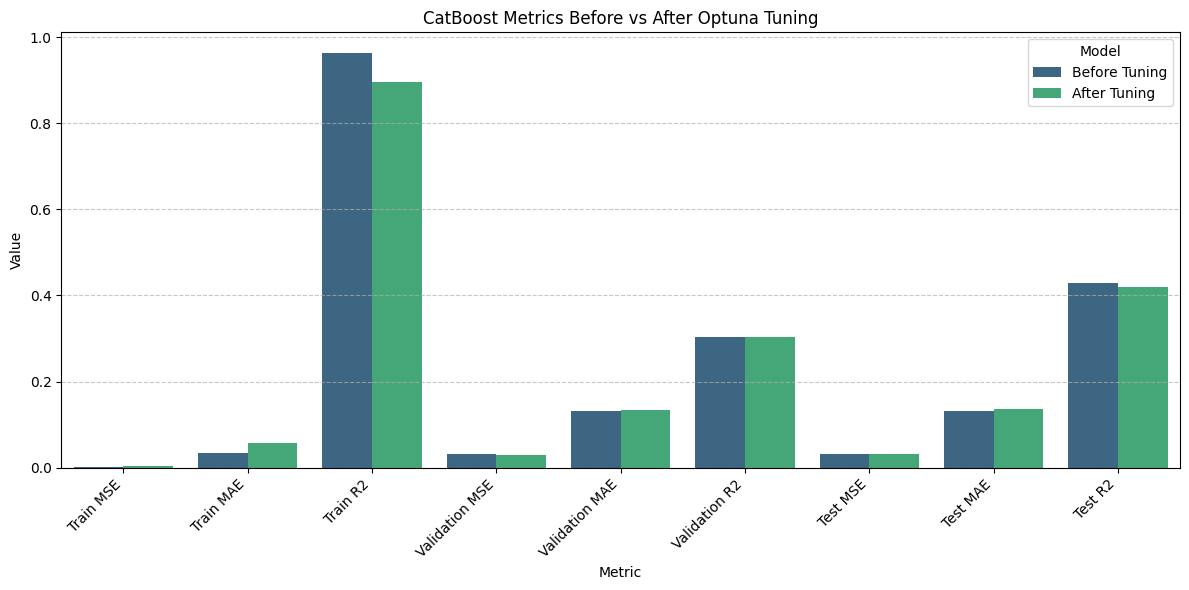

In [45]:
# Comparing metrics before and after tuning

comparison_table = pd.DataFrame({
    "Before Tuning": [
        Catboost_before_tuning["Train MSE"], Catboost_before_tuning["Train MAE"], Catboost_before_tuning["Train R2"],
        Catboost_before_tuning["Val MSE"], Catboost_before_tuning["Val MAE"], Catboost_before_tuning["Val R2"],
        Catboost_before_tuning["Test MSE"], Catboost_before_tuning["Test MAE"], Catboost_before_tuning["Test R2"]
    ],
    "After Tuning": [
        Catboost_after_tuning["Train MSE"], Catboost_after_tuning["Train MAE"], Catboost_after_tuning["Train R2"],
        Catboost_after_tuning["Val MSE"], Catboost_after_tuning["Val MAE"], Catboost_after_tuning["Val R2"],
        Catboost_after_tuning["Test MSE"], Catboost_after_tuning["Test MAE"], Catboost_after_tuning["Test R2"]
    ]
}, index=[
    "Train MSE", "Train MAE", "Train R2",
    "Validation MSE", "Validation MAE", "Validation R2",
    "Test MSE", "Test MAE", "Test R2"
])

comparison_long = comparison_table.reset_index().melt(
    id_vars="index",
    var_name="Model",
    value_name="Value"
)
comparison_long.rename(columns={"index": "Metric"}, inplace=True)

# Visualization
plt.figure(figsize=(12,6))
sns.barplot(x="Metric", y="Value", hue="Model", data=comparison_long, palette="viridis")
plt.title("CatBoost Metrics Before vs After Optuna Tuning")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Value")
plt.xlabel("Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


In [46]:
# Prediction + user id and segmentation to csv
# Use the ids_test Series obtained from the split
output_df = pd.DataFrame({
    "cleaned_product_id": ids_test.values,
    "true_discount": y_test.values,
    "predicted_discount": y_test_pred
})

def assegna_segmento_pricing(discount_percentage):
    if discount_percentage < 0.20:
        return ("Low Discount", 0, "Discounts below 20%")
    elif 0.20 <= discount_percentage < 0.50:
        return ("Medium Discount", 1, "Discounts between 20% and 50%")
    elif 0.50 <= discount_percentage < 0.80:
        return ("High Discount", 2, "Discounts between 50% and 80%")
    else:
        return ("Extreme Discount", 3, "Discounts over 80%")

def assegna_segmento_rating(rating):
    if rating < 3.5:
        return ("Low Rating", 0, "Ratings below 3.5 - dissatisfaction.")
    elif 3.5 <= rating < 4.2:
        return ("Medium Rating", 1, "Ratings between 3.5 and 4.2 - average customer satisfaction.")
    else:
        return ("High Rating", 2, "Ratings 4.2 or higher - high customer satisfaction.")

preds = final_model.predict(x_test_final)

predicted_discounts_df = pd.DataFrame(x_test_final.copy())
predicted_discounts_df['product_id'] = ids_test.values        # ID
predicted_discounts_df['true_discount'] = y_test.values
predicted_discounts_df['predicted_discount_percentage'] = preds

# Pricing segmentation
segment_info_pricing = predicted_discounts_df['predicted_discount_percentage'].apply(assegna_segmento_pricing)
predicted_discounts_df['pricing_segment'] = segment_info_pricing.apply(lambda x: x[0])
predicted_discounts_df['pricing_segment_description'] = segment_info_pricing.apply(lambda x: x[2])

# Rating segmentation
segment_info_rating = predicted_discounts_df['rating'].apply(assegna_segmento_rating)
predicted_discounts_df['rating_segment'] = segment_info_rating.apply(lambda x: x[0])
predicted_discounts_df['rating_segment_description'] = segment_info_rating.apply(lambda x: x[2])

# Rating count log segmentation
labels = [
    "poco noto", # bin 0
    "emergente", # bin 1
    "moderatamente popolare", # bin 2
    "molto popolare", # bin 3
    "best seller"  # bin 4
    ]

mapping = {i: label for i, label in enumerate(labels)}
predicted_discounts_df['rating_count_segment'] = predicted_discounts_df['rating_count_log_quintile'].map(mapping)

# Export
predicted_discounts_df.to_csv('/content/drive/MyDrive/24HBS_AI/PW/amazon_model_output.csv', index=False)
print(predicted_discounts_df)

     rating  review_sentiment  rating_count_log  rev_10  rev_amazing  \
0       4.4          0.322647          7.878913     0.0     0.000000   
1       4.5          0.511111          8.679822     0.0     0.000000   
2       4.0          0.494444         10.338770     0.0     0.000000   
3       3.9          0.347708          9.565704     0.0     0.000000   
4       4.3          0.396591          7.821643     0.0     0.000000   
..      ...               ...               ...     ...          ...   
202     4.1          0.091204          5.697093     0.0     0.000000   
203     3.9          0.344444          9.482503     0.0     0.000000   
204     3.8          0.273611          6.289716     0.0     0.000000   
205     2.8          0.144589          4.700480     0.0     0.182178   
206     4.2          0.360303          5.958425     0.0     0.000000   

     rev_amazon  rev_android  rev_app  rev_audio  rev_available  ...  \
0      0.000000          0.0      0.0   0.000000            0.0


Elenco completo delle feature con importanza > 0:
                                     Feature  Importance
                   macro_officepaperproducts      3.9382
                            rating_count_log      3.7879
                                  name_cable      3.4904
                                 name_holder      2.1766
                                  about_sync      1.9501
                             name_compatible      1.8149
                 macro_kitchenhomeappliances      1.7123
                             cat_smartphones      1.4502
                                   rev_price      1.3200
                               name_purifier      1.2869
                                   about_fit      1.2387
                                 about_watts      1.1883
                                 about_cable      1.1232
                                 about_watch      1.1002
          macro_headphonesearbudsaccessories      1.0689
                                     

/tmp/ipython-input-1878284172.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10), palette="viridis")


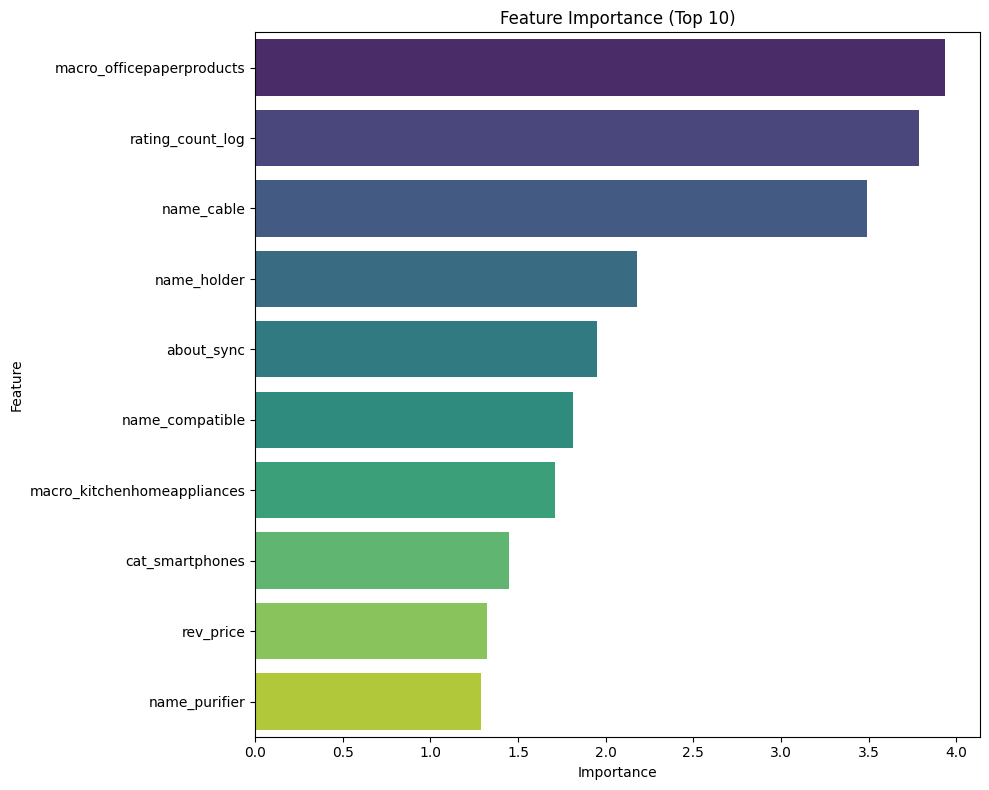

In [60]:
# Feature importance

importance_values = final_model.feature_importances_

# Dataframe
feat_imp = pd.DataFrame({
    "Feature": x_train_final.columns,
    "Importance": importance_values
})
feat_imp["Importance"] = feat_imp["Importance"].round(4)
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

#
feat_imp.to_csv('/content/drive/MyDrive/24HBS_AI/PW/feature_importance.csv', index=False)

# Feature importance > 0
feat_imp_nonzero = feat_imp[feat_imp["Importance"] > 0]
print("\nElenco completo delle feature con importanza > 0:")
print(feat_imp_nonzero.to_string(index=False))

# Top 10 feature
plt.figure(figsize=(10,8))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10), palette="viridis")
plt.title("Feature Importance (Top 10)")
plt.tight_layout()
plt.show()


In [51]:
#top 5 feature in area_cat
importance = final_model.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": x_train_final.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

area_cat_features = feat_imp[feat_imp["Feature"].str.startswith("cat_")]

# Top5
top5_area_cat = area_cat_features.head(5)

print("Top 5 features in area_cat:")
print(top5_area_cat)

Top 5 features in area_cat:
                     Feature  Importance
617          cat_smartphones    1.450202
619         cat_smartwatches    0.854123
621            cat_usbcables    0.192170
611             cat_lapdesks    0.008133
623  cat_wirelessusbadapters    0.000000



Cumulative Feature Importance
                       Feature  Importance  Cumulative Importance
635  macro_officepaperproducts      3.9382               0.039382
2             rating_count_log      3.7879               0.077261
440                 name_cable      3.4904               0.112165
494                name_holder      2.1766               0.133930
372                 about_sync      1.9501               0.153431
..                         ...         ...                    ...
477              name_foldable      0.0000               1.000000
478                  name_free      0.0000               1.000000
479              name_function      0.0000               1.000000
480                name_galaxy      0.0000               1.000000
500               name_instant      0.0000               1.000000

[818 rows x 3 columns]


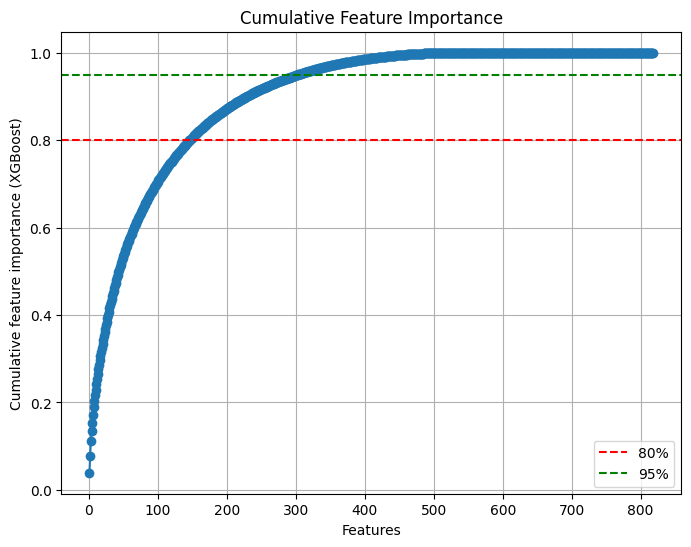

In [55]:
from catboost import Pool

importance_df = feat_imp.copy()

# Cumulative importance
importance_df["Cumulative Importance"] = (
    importance_df["Importance"].cumsum() / importance_df["Importance"].sum()
)

print("\nCumulative Feature Importance")
print(importance_df)

n_features_80 = (importance_df["Cumulative Importance"] <= 0.80).sum()
n_features_95 = (importance_df["Cumulative Importance"] <= 0.95).sum()

# Visualization
plt.figure(figsize=(8,6))
plt.plot(range(1, len(importance_df)+1), importance_df["Cumulative Importance"], marker="o")
plt.axhline(y=0.80, color="red", linestyle="--", label="80%")
plt.axhline(y=0.95, color="green", linestyle="--", label="95%")
plt.title("Cumulative Feature Importance")
plt.xlabel("Features")
plt.ylabel("Cumulative feature importance (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()


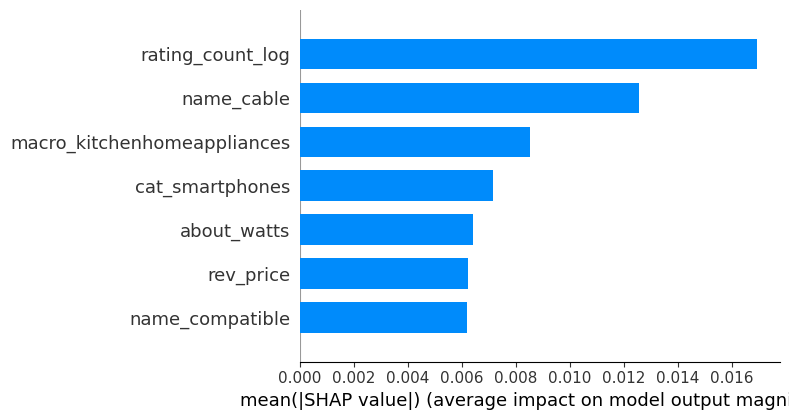

-------------------------------------------------------------------------------------------------


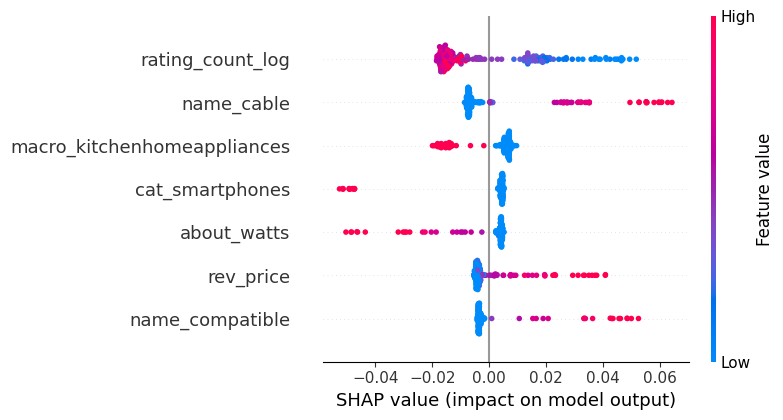

In [59]:
#SHAP analysis
import shap

explainer = shap.Explainer(final_model, x_test_final)
shap_values = explainer.shap_values(x_test_final)

# top 5 features - confirms
shap.summary_plot(shap_values, x_test_final, plot_type="bar", max_display=7)

print("-------------------------------------------------------------------------------------------------")

# Scatterplot to understand how the prediction works
shap.summary_plot(shap_values, x_test_final, max_display=7)


**Key Findings from the Model**

Rating Count emerged as one of the most **influential driver of predicted discounts**.
- Products with higher ratings and large volumes of reviews require lower discounts to sustain sales, reflecting strong consumer trust and brand resilience.
- Conversely, items with low ratings or few reviews depend on aggressive discounting to stimulate demand.

Category Effects were significant:
- Smartphones and Smart Televisions showed high price elasticity, requiring deeper discounts to compete in saturated markets.
- Accessories (USB cables, headphones) displayed moderate elasticity, where smaller discounts were sufficient to drive conversion.

Sentiment Analysis of reviews added explanatory power: positive sentiment correlated with reduced discount needs, while negative sentiment amplified the necessity of promotional pricing.

SHAP values confirmed the non‑linear impact of rating count: once a product surpasses a threshold of ~10,000 reviews, the marginal effect of additional reviews on discount requirements diminishes.